Missing data is a common issue in statistical analyses and research, impacting the validity and interpretability of results. Understanding the nature of missing data, its types, impacts, and strategies to address it is crucial for researchers and data analysts.

# Issues

Dealing with missing data is a common challenge in data analysis and machine learning, and it's crucial to handle it carefully because it can significantly impact the results of your study or model. Here are some key issues and considerations regarding missing data:

## **Bias in Analysis**

- If the data missing is not random (Missing Not At Random - MNAR) _(See Section 2)_ or if the mechanism causing the data to be missing is related to the missing data itself, simply removing or imputing data without considering this can lead to biased results. For example, if people with higher incomes are less likely to disclose them in a survey, analyses based on the remaining data will not accurately represent the entire population.

## **Loss of Information**

- When you remove observations with missing values, especially if you're using listwise deletion _(See Section 3)_, you're potentially throwing away valuable information. The remaining data might not be enough to accurately train a machine learning model or to make comprehensive statistical inferences.

## **Reduced Statistical Power**

- Statistical power is the probability that a test will correctly reject a false null hypothesis (i.e., detect an effect if there is one). Missing data reduces the sample size, which can diminish the statistical power of your tests. This means you might not detect a real effect or difference because of the reduced dataset size.

## **Increased Standard Errors**

- Standard errors estimate the variability of your estimate from the true population parameter. Missing data, especially when not handled properly, can lead to increased standard errors, making your estimates less precise.

## **Complexities in Analysis**

- Dealing with missing data often requires sophisticated statistical techniques, which can complicate the analysis. For example, multiple imputation is more accurate and less biased compared to single imputation but requires careful consideration and understanding to implement correctly _(See Section 3)_.

## **Assumptions about Missingness**

- Different methods for handling missing data rely on various assumptions about why the data is missing _(See Section 2)_. For instance:
   - **Missing Completely At Random (MCAR)**: The reason for the missing data is completely random and not related to the data itself or any other measured variables.
   - **Missing At Random (MAR)**: The missingness is related to some of the observed data but not the missing data itself.
   - **Missing Not At Random (MNAR)**: The missingness is related to the value of the missing data itself.

   Choosing the wrong method for the type of missingness can lead to incorrect conclusions.

## **Difficulty in Interpretation**

- Data imputation or deletion methods can change the distribution of your data, complicating the interpretation of your results. For example, mean imputation can underestimate the variance in your data, while model-based imputation might introduce bias if the model assumptions are not met.

# Types of Missing Data

There are three main types of missing data, each with different implications for analysis. To demonstrate these types, we use the __National Health and Nutrition Examination Survey (NHANES)__. The NHANES dataset is a program of studies designed to assess the health and nutritional status of adults and children in the United States. The survey combines interviews and physical examinations. It includes a wide range of variables from demographic data, dietary information, to laboratory data, many of which have missing values due to non-response or other reasons.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
# Null values are marked as " ?"
df = pd.read_csv('./Data/adult.csv', na_values=' ?')
df.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

Missing Values Summary:
 age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


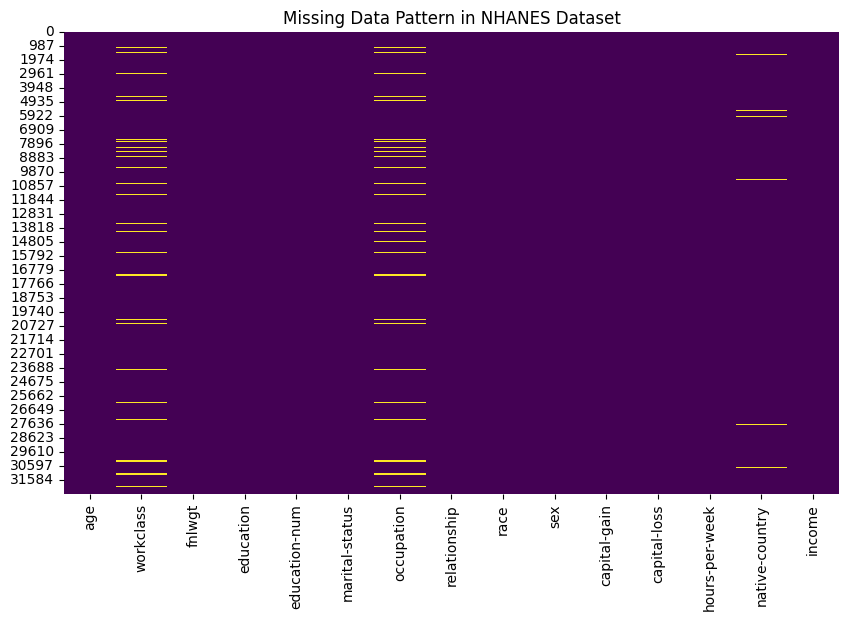

In [3]:
# Summarize missing values to have a general idea of what we are dealing with
missing_values_summary = df.isnull().sum()
print("Missing Values Summary:\n", missing_values_summary)

# Visualize missingness pattern
plt.figure(figsize=(10, 6))
plt.title('Missing Data Pattern in NHANES Dataset')
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

## Missing Completely at Random (MCAR)

- **Definition**: Data is missing completely at random (MCAR) if the probability of being missing is the same for all observations. The missingness of data is unrelated to any study or measurement variables.
- **Implication**: MCAR allows for unbiased estimates of means, proportions, and other statistical measures, as the missingness does not depend on the data itself.

In [4]:
from scipy.stats import chi2_contingency


# Create a new DataFrame to store information about missingness
missing_df = pd.DataFrame()
for col in df.columns:
    missing_df[col] = df[col].isnull()

# Perform chi-square tests
p_values = pd.Series(index=df.columns)
for col in missing_df.columns:
    observed = pd.crosstab(missing_df[col], df[col].notnull())
    chi2, p, dof, expected = chi2_contingency(observed)
    p_values[col] = p

# Print p-values
print(p_values)


age               1.0
workclass         0.0
fnlwgt            1.0
education         1.0
education-num     1.0
marital-status    1.0
occupation        0.0
relationship      1.0
race              1.0
sex               1.0
capital-gain      1.0
capital-loss      1.0
hours-per-week    1.0
native-country    0.0
income            1.0
dtype: float64


The chi-squared test results show p-values for the hypothesis test of independence between each variable and the presence of missing values in other variables. Here's how to interpret these p-values:

- A p-value close to 1 indicates that there is no evidence of association between the presence of missing values in that variable and the presence or absence of non-missing values in other variables.
- A p-value close to 0 suggests that there is an association; that is, the missingness of the data in that variable depends on the values of other variables.

A p-value of 1 for most variables suggests that missingness in those variables is independent of other variables, which supports the Missing Completely at Random (MCAR) assumption for those variables, as in our case, indicate the lack of missing data in those columns. However, for the variables `workclass`, `occupation`, and `native-country` where the p-values are 0, this indicates an association between missingness and other variables, suggesting the data may not be MCAR for these variables.

It's important to consider that chi-squared tests can be sensitive to large sample sizes, which means that even a small deviation from perfect independence can result in a small p-value when the sample size is large. Hence, you should also consider the practical significance of the association, not just the statistical significance.

For a definitive conclusion about whether your data is MCAR, MAR, or MNAR, you would typically need to consider additional information about the data collection process and potentially use more advanced statistical techniques. However, the chi-squared test provides a good initial assessment of the missing data mechanism.

##  Missing at Random (MAR)

- **Definition**: Data is missing at random (MAR) if the probability of data being missing is related to some observed data but not the missing data itself.
- **Implication**: MAR permits the use of methods that can handle missingness appropriately, as long as the model accounts for the variables related to the missingness. Estimates can be unbiased if the model correctly includes all variables related to the missingness.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Create a binary indicator (0 for non-missing, 1 for missing) for the variable 'workclass'
df['workclass_missing'] = df['workclass'].isnull().astype(int)

# Select features for the logistic regression model. Exclude 'workclass' and any other variables with missing values.
# Here we're assuming 'age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', and 'income' have no missing values and can be used as predictors.
features = ['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']

# Convert categorical variables to dummy variables (one-hot encoding)
df_dummies = pd.get_dummies(df[features], drop_first=True)

# Prepare the data for logistic regression
X = df_dummies
y = df['workclass_missing']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict the probability of missingness
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model using AUC (Area Under the Curve)
roc_value = roc_auc_score(y_test, y_pred_prob)

print(f'AUC: {roc_value}')


AUC: 0.7342923737070605


An AUC (Area Under the Receiver Operating Characteristic Curve) of 0.7342923737070605 is a value between 0.5 and 1.0, which indicates that the logistic regression model we have built to predict the missingness of the 'workclass' variable has a good ability to distinguish between cases with missing values and cases without missing values.

Here's how to interpret the AUC value:

- **0.5**: This is the AUC value you would expect from a model that has no discriminative ability at all. It is equivalent to random guessing.
- **0.5 < AUC < 0.7**: This suggests that the model has a fair ability to distinguish between the two cases.
- **0.7 ≤ AUC < 0.8**: This is considered good and implies that the model has a reasonably high ability to differentiate between cases with and without missing values.
- **0.8 ≤ AUC < 0.9**: This is very good and indicates that the model has a strong discriminative ability.
- **0.9 ≤ AUC < 1.0**: This is excellent and suggests that the model has a very strong ability to distinguish between the cases.
- **AUC = 1.0**: This would mean the model perfectly discriminates between all positive and all negative cases.

In our case, an AUC of approximately 0.734 suggests that the logistic regression model is fairly good at using the observed data to predict whether the 'workclass' value is missing or not. This indicates that there is a relationship between the missingness of 'workclass' and the observed data, which supports the Missing at Random (MAR) assumption rather than MCAR. It means that the missing data in 'workclass' is not random and is likely related to other variables in your dataset.

However, it's important to note that AUC alone doesn't prove the missing data mechanism to be MAR. It's also possible that some unobserved variables, if they were included in the model, could change the AUC score. The interpretation should also be contextualized within the understanding of the data collection process and domain knowledge.

## Missing Not at Random (MNAR)

- **Definition**: Data is missing not at random (MNAR) if the missingness depends on the unobserved data itself.
- **Implication**: MNAR introduces bias that is challenging to address without making unverifiable assumptions about the missing data mechanism.

Identifying Missing Not at Random (MNAR) is inherently challenging because MNAR implies that the probability of missing data is related to the missing values themselves, which you don't observe. Unlike MCAR and MAR, there's no statistical test that can definitively tell you whether your data is MNAR because it depends on information that is not present in your dataset.

However, you can sometimes infer that data might be MNAR through indirect evidence or by using domain knowledge. For example, if you know that individuals with higher incomes are less likely to report their income, and you observe missingness in income data, you might suspect that the data is MNAR.

A possible approach to explore MNAR is to analyze patterns that could be indicative of MNAR, such as:

1. **High missingness in variables that could be sensitive or stigmatized** (e.g., income, mental health history, substance use), which might indicate that respondents are more likely to withhold or not report such information.

2. **Comparing patterns of missingness between different subgroups** that may have different incentives to hide or not report certain information.

3. **Using proxy variables or external data** to infer what the missing data might be like and whether its absence is informative.

Here is a conceptual approach to investigate MNAR:

In [37]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Check for missing values in 'workclass' and create the binary indicator
df['occupation_missing'] = df['occupation'].isnull().astype(int)

# Check the distribution of the workclass_missing to ensure there are both 0s and 1s
#print(df['workclass_missing'].value_counts())

# Assuming other variables do not have missing values and can be used as predictors
features = [
    'age', 'education', 'education-num', 'marital-status', 'relationship',
    'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week'
]

# Convert categorical variables to dummy variables
df_dummies = pd.get_dummies(df[features], drop_first=True)

# Prepare the data
X = df_dummies
y = df['occupation_missing']

# Check if both classes 0 and 1 are present in y
if y.nunique() == 2:
    # Perform stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)

    # Fit the logistic regression model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Predict the probability of missingness
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    roc_value = roc_auc_score(y_test, y_pred_prob)

    print(f'AUC for predicting missingness in occupation: {roc_value}')
else:
    print(
        "Missingness indicator for 'occupation' does not have both classes. Unable to perform logistic regression."
    )

AUC for predicting missingness in occupation: 0.7351575140382602


An AUC of 0.7351575140382602 for predicting missingness in the `occupation` variable is considered good. It indicates that the logistic regression model has a reasonably strong ability to distinguish between instances where `occupation` is missing and where it is observed, based on the other variables in your dataset.

Here’s what this suggests about the missingness of `occupation`:

- **Not Random**: A value significantly greater than 0.5 implies that the missingness of `occupation` is not random and is systematically related to other observed variables in the dataset.
- **Potentially MAR**: This pattern is consistent with Missing at Random (MAR), where the probability of missing data on `occupation` is related to other observed data but not to the missing `occupation` data itself. For example, people with certain education levels or in certain income brackets might be more likely to leave the `occupation` field blank.
- **MNAR Uncertainty**: While the predictability of missingness is consistent with MAR, it does not rule out Missing Not at Random (MNAR). If the reason for missingness is related to the `occupation` itself (e.g., people in certain occupations are reluctant to disclose it), the missingness could still be MNAR.

To sum up, the AUC value suggests that there is a pattern to the missingness in the `occupation` variable which can be somewhat predicted by other features in your dataset. However, without additional information about why data is missing for `occupation`, you cannot definitively determine if it is MAR or MNAR. This value indicates a good predictive ability but does not provide as strong evidence of a systematic missingness pattern as an AUC closer to 1 would.

# Strategies for Dealing with Missing Data

Several strategies can be employed to address missing data, each with its advantages and limitations.

## Imputation Methods

Imputation involves filling in missing data with plausible values.

### Mean/Median Imputation: 
Replacing missing values with the mean or median of the observed data. Simple but can underestimate variability.

In this particular case, our missing values exist only for categorical features in which we can not use mean or median but remember that such a choice depends on the specific data you are dealing with and the goal of the analysis. Imputation with mean, median or mode should not be considered as an always-valid action, regardless of the context.

To demonstrate the process, we use mode of `native-country` to replace its missing values:

In [24]:
# Check for missing values in the dataset
print("Missing values before imputation:")
print(df.isnull().sum())

# To impute a numerical feature, you can use .mean() or .median()
# For mean imputation
df['native-country'].fillna(df['native-country'].mode().values[0], inplace=True)

# Alternatively, for median imputation
# df['hours-per-week'].fillna(df['hours-per-week'].median(), inplace=True)

# Check for missing values after imputation to verify
print("\nMissing values after imputation:")
print(df.isnull().sum())

Missing values before imputation:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Missing values after imputation:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64


### Multiple Imputation: 
Creates several imputed datasets using a random draw from the distribution of observed data, then combines results from each dataset. Accounts for the uncertainty of missing data.

In [25]:
# Check initial missing values for 'occupation'
print("Missing values in 'occupation' before imputation:",
      df['occupation'].isnull().sum())


# Function to impute missing values by randomly sampling existing values
def impute_categorical(df, column_name, iterations=5):
    for i in range(iterations):
        df[f'{column_name}_imputed_{i+1}'] = df[column_name]
        missing = df[column_name].isnull()
        df.loc[missing, f'{column_name}_imputed_{i+1}'] = np.random.choice(
            df[column_name].dropna(), size=sum(missing))


# Impute 'occupation' column
impute_categorical(df, 'occupation')

# Display results
print("\nImputed Data (first few rows for each imputed version):")
print(df[['occupation'] + [f'occupation_imputed_{i+1}'
                           for i in range(5)]].head())

Missing values in 'occupation' before imputation: 1843

Imputed Data (first few rows for each imputed version):
           occupation occupation_imputed_1 occupation_imputed_2  \
0     Exec-managerial      Exec-managerial      Exec-managerial   
1   Handlers-cleaners    Handlers-cleaners    Handlers-cleaners   
2   Handlers-cleaners    Handlers-cleaners    Handlers-cleaners   
3      Prof-specialty       Prof-specialty       Prof-specialty   
4     Exec-managerial      Exec-managerial      Exec-managerial   

  occupation_imputed_3 occupation_imputed_4 occupation_imputed_5  
0      Exec-managerial      Exec-managerial      Exec-managerial  
1    Handlers-cleaners    Handlers-cleaners    Handlers-cleaners  
2    Handlers-cleaners    Handlers-cleaners    Handlers-cleaners  
3       Prof-specialty       Prof-specialty       Prof-specialty  
4      Exec-managerial      Exec-managerial      Exec-managerial  


Ok, let's explain what happened exactly in the `impute_categorical` function above:

The `impute_categorical` function is designed to address missing values in a categorical column of a DataFrame by applying a simple form of multiple imputation. 

Here's a step-by-step explanation of what happens inside this function:

1. **Iterative Imputation**:
   - For each iteration (up to the number specified by `iterations`), the function performs the following steps:
     - A new column is created in the DataFrame for each iteration, named by appending `_imputed_{iteration_number}` to the original column name. This ensures that each imputed version of the dataset is stored separately.
     - The function identifies rows where the original column has missing values (`df[column_name].isnull()`).
     - For each missing entry, it randomly selects a non-missing value from the same column and uses it to fill the missing slot. This selection is done using `np.random.choice(df[column_name].dropna(), size=sum(missing))`, where:
       - `df[column_name].dropna()` creates a series of non-missing values from the column.
       - `np.random.choice(...)` randomly selects one or more values from this series.
       - `size=sum(missing)` specifies the number of random selections to make, equal to the total number of missing values in the column.

2. **Result**:
   - The DataFrame is updated with new columns, each representing a different imputed version of the original column. Each of these columns has the same missing values filled in, but the values used for imputation may differ across iterations due to the random selection process.
   - This approach mimics multiple imputation by creating several plausible datasets where the missing values are filled in differently each time, reflecting the uncertainty around the true values that should replace the missing data.

3. **Implications**:
   - By generating multiple imputed versions of the data, analysts can perform their analyses on each version separately and then combine the results. This method acknowledges the uncertainty inherent in imputation and can lead to more robust conclusions than single imputation methods.
   - However, it's important to note that this simplistic approach does not model the relationships between variables for imputation, unlike more sophisticated multiple imputation methods like MICE (Multiple Imputation by Chained Equations). Therefore, while helpful for demonstration and simple applications, it might not fully capture the complexity of the data's structure in more detailed analyses.

The method above, while useful, can be only applied to categorical features. Let's see how can we implement the same method for a numerical feature (_we don't have a numerical feature with missing data in our dataset but for educational purpose, let's assume that the column `age` has some missing values_)

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

# Assuming 'age' has missing values and we're using 'IterativeImputer'
imputer = IterativeImputer(estimator=RandomForestClassifier(),
                           max_iter=10,
                           random_state=0)

# This example assumes 'age' is numerical and has missing values, which is just for demonstration
# Normally, you would convert categorical to numerical (e.g., via encoding) before using IterativeImputer
df['age_imputed'] = imputer.fit_transform(df[['age']])

# Check results
print(df[['age', 'age_imputed']].head())

   age  age_imputed
0   50         50.0
1   38         38.0
2   53         53.0
3   28         28.0
4   37         37.0


### Model-Based Imputation: 
Uses regression models or machine learning algorithms to predict missing values based on observed data.

Model-based imputation involves using statistical models or machine learning algorithms to predict and fill in missing values based on the patterns found in the observed data. This approach can be more accurate than simpler methods like mean/median imputation, especially when the relationships between variables are complex. Here, we'll demonstrate how to perform model-based imputation for the "workclass" column in a dataset. We'll use a simple classification model for this purpose, where the target variable is "workclass" and the features are other columns in the dataset.

For this example, I'll use a RandomForestClassifier from `scikit-learn`, as it's versatile and handles categorical variables well once they're encoded properly.

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

### Step 1: Preparing the Data

# Let's reload the dataset again to make sure that the previous operations
# haven't altered it

df = pd.read_csv('./Data/adult.csv', na_values=' ?')
df.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

# Assuming 'workclass' has missing values and other columns will be used as features
# First, encode categorical data. Here, for simplicity, we encode all object-type columns
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    if column != 'workclass':  # Exclude target column for now
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le

# Separate rows where 'workclass' is missing from those where it's not
df_missing_workclass = df[df['workclass'].isnull()]
df_not_missing_workclass = df.dropna(subset=['workclass'])

# Encode 'workclass' separately to avoid fitting LabelEncoder on data containing NaN
le_workclass = LabelEncoder()
df_not_missing_workclass['workclass'] = le_workclass.fit_transform(
    df_not_missing_workclass['workclass'].astype(str))

### Step 2: Model Training

# Prepare features (X) and target (y)
X = df_not_missing_workclass.drop('workclass', axis=1)
y = df_not_missing_workclass['workclass']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set to evaluate the model
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

### Step 3: Imputing Missing Values

# Predict 'workclass' for rows with missing 'workclass'
X_missing_workclass = df_missing_workclass.drop('workclass', axis=1)
predicted_workclass = clf.predict(X_missing_workclass)

# Fill in missing 'workclass' values in the original dataframe
df_missing_workclass['workclass'] = le_workclass.inverse_transform(
    predicted_workclass)

# Combine back into a single DataFrame
df_imputed = pd.concat([df_not_missing_workclass, df_missing_workclass])

df_imputed.sample(5)

Accuracy: 0.7458664236427548


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7966,28,5,214689,1,7,4,2,1,4,1,0,0,40,38,0
2503,61,3,146788,5,4,2,13,0,4,1,0,0,40,38,0
9975,37,3,291981,11,9,0,6,1,4,1,0,0,40,38,0
19440,50,3,162327,15,10,2,5,0,4,1,0,0,50,38,0
25607,36,3,187983,9,13,2,9,5,4,0,0,0,40,38,0


## Dropping Missing Values

- **Listwise Deletion**: Removes any observation with missing data. Simple but can lead to significant data loss and bias if the missingness is not MCAR.
- **Pairwise Deletion**: Uses all available data for each analysis without dropping entire observations. Preserves more data but can lead to inconsistent results across analyses.

### Listwise Deletion

Listwise deletion, also known as complete case analysis, involves removing any rows from the dataset that contain at least one missing value. This method is straightforward but may result in significant data loss, especially if missingness is widespread.

In [33]:
df = pd.read_csv('./Data/adult.csv', na_values=' ?')
df.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

# Display the original number of rows
print("Original number of rows:", df.shape[0])

# Apply listwise deletion
df_listwise = df.dropna()

# Display the number of rows after listwise deletion
print("Number of rows after listwise deletion:", df_listwise.shape[0])

Original number of rows: 32560
Number of rows after listwise deletion: 30161


### Pairwise Deletion

Pairwise deletion involves using all available data for each analysis without dropping entire observations. Unlike listwise deletion, it doesn't discard entire rows due to a single missing value. Instead, it calculates statistics or models using all available pairs of variables. This method can be more complex to implement, as it depends on the specific analysis or statistical model being used. For example, when calculating correlations, each correlation coefficient is calculated using only the non-missing data for the pair of variables involved.

Implementing pairwise deletion generally involves custom logic tailored to the specific analysis or the use of statistical software/packages that support this method natively. Below is a conceptual example of how you might approach pairwise deletion for calculating correlation coefficients in Python:

In [34]:
# Assuming 'age' and 'hours-per-week' might have missing values,
# and you're interested in calculating the correlation coefficient between them

# For demonstration, let's calculate correlation without dropping rows globally
age = df['age']
hours_per_week = df['hours-per-week']

# Calculate correlation using pairwise deletion
valid_indices = np.logical_and(~np.isnan(age), ~np.isnan(hours_per_week))  # Indices with non-NaN values for both
correlation = np.corrcoef(age[valid_indices], hours_per_week[valid_indices])

print("Correlation coefficient (pairwise deletion):", correlation[0, 1])

Correlation coefficient (pairwise deletion): 0.06875574320157964


## Using Algorithms that Support Missing Values

Some statistical models and machine learning algorithms can handle missing data directly without the need for imputation or deletion.

- **Decision Trees and Random Forests**: Can split data using nodes that separate missing from non-missing values.
- **Certain Bayesian Methods**: Can incorporate missing data as part of the model, using the observed data to inform the distribution of the missing values.